# Periodic Electronic Structure: Encoding in First Quantization

<font size="3">

<hr>
Copyright (c) 2024 Massachusetts Institute of Technology 

SPDX-License-Identifier: BSD-2-Clause
<hr><hr>
</font>

In [1]:
import cirq

from pyLIQTR.ProblemInstances.getInstance   import *
from pyLIQTR.BlockEncodings.getEncoding     import *
from pyLIQTR.utils.resource_analysis        import estimate_resources
from pyLIQTR.qubitization.phase_estimation  import QubitizedPhaseEstimation

import numpy as np
import matplotlib.pyplot as plt
from pyLIQTR.circuits.operators.tests.utils import ignore_bookkeeping
from pyLIQTR.utils.call_graphs import show_call_graph
from pyLIQTR.utils.printing import openqasm

##### <u>References:</u>
[1]<a id='ref1'></a> [Fault-Tolerant Quantum Simulations of Chemistry in First Quantization](https://arxiv.org/abs/2105.12767)

[2]<a id='ref2'></a> [Quantum computing for corrosion-resistant materials and anti-corrosive coatings design](https://arxiv.org/abs/2406.18759)

[3]<a id='ref3'></a> [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662)

# Overview

This notebook walks through how to encode and perform resource analysis for periodic electronic structure Hamiltonians in a first quantized plane wave basis.

# Background

<u>The Hamiltonian:</u>

The first quantized block encoding relies on the linear combination of unitaries (LCU) framework where the Hamiltonian unitaries are expressed in the first quantized representation. Here, we focus on molecular Hamiltonians in the first quantized plane wave basis, which under the Born-Oppenheimer approximation can be expressed as

\begin{align*}
H &= T + U + V + \frac{1}{2}\sum_{\ell\neq\kappa=1}^L \frac{\zeta_\ell \zeta_\kappa}{||R_\ell - R_\kappa||} 
&T& = \sum_{i=1}^\eta \sum_{p\in G} \frac{||k_p||^2}{2} |p\rangle \langle p|_i \\
U &= -\frac{4\pi}{\Omega} \sum_{\ell=1}^{L}\sum_{i=1}^{\eta}\sum_{\substack{p,q\in G \\ p\neq q}} \left( \zeta_\ell \frac{e^{ik_{q-p}\cdot R_\ell}}{||k_{p-q}||^2}\right) |p\rangle \langle q|_i 
&V& = \frac{2\pi}{\Omega} \sum_{i\neq j = 1}^\eta \sum_{p,q \in G} \sum_{\substack{\nu\in G_0 \\ (p+\nu)\in G\\ (q-\nu)\in G}} \frac{1}{||k_\nu||^2} |p+\nu\rangle\langle p|_i |q-\nu\rangle\langle q|_j,
\end{align*}

where $\eta$ is the number of electrons, $L$ is the number of atoms, $R_\ell$ is the location of each atom, $\zeta_\ell$ is the atomic number, $\Omega$ is the computational cell volume, $k_p=\frac{2\pi p}{\Omega^{1/3}}$ is a 3-dimensional recipricol lattice vector, $p\in G$,

$$
G = \left[-\frac{N^{1/3}-1}{2}, \frac{N^{1/3}-1}{2} \right]^3 \subset \mathbb{Z}^3, \quad \quad \quad G_0 = \left[-N^{1/3}, N^{1/3} \right]^3 \subset \mathbb{Z}^3 \backslash \{(0,0,0)\},
$$
and $N$ is the number of plane waves making up the basis.

<u>The Block Encoding Operators:</u>

With the above target Hamiltonian represented as an LCU, one can construct the operators $\text{PREP}_H$ and $\text{SEL}_H$ such that

$$
\langle 0 | \text{PREP}^{\dagger}_H \cdot \text{SEL}_H \cdot \text{PREP}_H |0\rangle = \frac{H}{\lambda}
$$
block encodes the Hamiltonian, where $\lambda$ is the Hamiltonian norm. To realize this, we use the circuit implementations described in Section II of [[1]](#ref1). There, the block encoding operators are separated into components for the kinetic energy $T$ and the potentials $U+V$ such that

$$
\langle 0 | \text{PREP}^{\dagger}_T \cdot \text{SEL}_T \cdot \text{PREP}_T |0\rangle = \frac{T}{\lambda_T}, \quad\quad
\langle 0 | \text{PREP}^{\dagger}_{U+V} \cdot \text{SEL}_{U+V} \cdot \text{PREP}_{U+V} |0\rangle = \frac{U+V}{\lambda_U + \lambda_V}.
$$

The full Hamiltonian can then be block encoded using an additional ancilla qubit to control whether the $T$ or $U+V$ operators are applied, weighted such that the overall normalization factor is $\lambda_T+\lambda_U+\lambda_V$. Since the approach used for preparing $U+V$ has a success probability close to 1/4, ie

$$
\widetilde{\text{PREP}}_{U+V}|0\rangle\otimes I \approx \frac{1}{2}|0\rangle \text{PREP}_{U+V} + \frac{\sqrt{3}}{2}|1\rangle \text{PREP}^{\perp}_{U+V},
$$
the ancilla qubit can be used to adjust the relative amplitudes between $T$ and $U+V$. Thus, the state preparation used is

$$
(\cos\theta|0\rangle + \sin\theta |1\rangle) \otimes \text{PREP}_T |0\rangle \otimes \widetilde{\text{PREP}}_{U+V}|0,0\rangle,
$$
and the selection operator is

$$
I\otimes I \otimes |0\rangle\langle 0|\otimes \text{SEL}_{U+V} +
|0\rangle\langle 0|\otimes\text{SEL}_{T} \otimes |1\rangle\langle 1|\otimes I +
|1\rangle\langle 1|\otimes I \otimes |1\rangle\langle 1|\otimes I
$$
where the selection of $T$ is conditioned on both the failure of the preparation of $U+V$ and the ancilla qubit being in state $|0\rangle$. Together, these give the block encoding

$$
\frac{U+V}{4(\lambda_U+\lambda_V)} + \frac{3T\cos^2\theta}{4\lambda_T}.
$$
The angle $\theta$ is then determined based on the condition that the above expression is proportional to $T+U+V$, resulting in $\theta = \arccos\sqrt{\lambda_T/3(\lambda_U+\lambda_V)}$. Note, this holds for the case $\lambda_T \lt 3(\lambda_U+\lambda_V)$ but the inverse of this can be handled by adjusting the select operator as discussed in [[1]](#ref1).

<!-- Ultimately, the preparation subroutine aims to prepare the quantum state
\begin{align*}
&(\cos\theta|0\rangle+\sin\theta|1\rangle)|+\rangle\frac{1}{\sqrt{\eta}}\left( \sqrt{\eta-1}|0\rangle\sum_{i\neq j=1}^\eta |i\rangle|j\rangle + |1\rangle\sum_{j=1}^\eta |j\rangle|j\rangle \right) \left( \frac{1}{\sqrt{3}}\sum_{w=0}^2|w\rangle \right)\\
&\otimes \left( \frac{1}{2^{n_p-1}-1} \sum_{r,s=0}^{n_p-2} 2^{(r+s)/2}|r\rangle|s\rangle \right) \left( \sqrt{\frac{\lambda_U}{\lambda_U+\lambda_V}}|0\rangle + \sqrt{\frac{\lambda_V}{\lambda_U+\lambda_V}}|1\rangle\right)\\
&\otimes \left( \sqrt{\frac{p_\nu}{\lambda_\nu}}|0\rangle\sum_{\nu\in G_0}\frac{1}{||\nu||}|\nu\rangle + \sqrt{1-p_\nu}|1\rangle|\nu^\perp\rangle \right) \left( \frac{1}{\sqrt{\sum_\ell\zeta_\ell}} \sum_{\ell=1}^L \sqrt{\zeta_\ell}|\ell\rangle \right)
\end{align*} -->

<u>The Application:</u>

For our resource analysis demonstration, we will look at a set of magnesium models that are representative of systems of interest to corrosion scientists. These models vary in complexity and were developed and studied in the context of quantum computing in [[2]](#ref2). There are 3 that model the corrosion process on a pure magnesium surface, and 1 magnesium-aluminum alloy model. The relevant properties of these systems are summarized in [Table 1](#tab1).

Quantum chemistry simulations for these types of systems are used for predicting electronic structure properties and improving material design. The use of a quantum computer in this workflow has the potential to improve the accuracy over classical simulations and to extend simulations to more complex systems. Below, we outline how to perform resource estimation for these systems using the first quantized block encoding and qubitized phase estimation.

<b>Table 1:</b> Properties of magnesium models relevant for the first quantized block encoding with $E_{\text{cut}}$=40 Ry.

| Model | $\eta$ | $\lambda_{\zeta} = \sum_\ell \zeta_\ell$ | $L$ | Cell size ($\text{\r{A}}$)| $N$ |
| --- | --- | --- | --- | --- | --- |
| Dimer | 860 | 860 | 76 | 12.7 x 12.7 x 19.9 | 23750 |
| Monolayer | 3344 | 3344 | 335 | 19.8 x 19.8 x 32.3 | 89528 |
| Cluster | 8044 | 8044 | 887 | 19.8 x 19.8 x 58.9 | 163172 |
| $\text{Mg}_{17}\text{Al}_{12}$ 2nd phase supercell | 10620 | 10620 | 1107 | 33.0 x 31.3 x 50.3 | 362880 |

<a id='tab1'></a>
Note $\eta = \lambda_\zeta$ for charge neutral systems.

# Problem set up: generate a ProblemInstance

The parameters needed for the first quantized encoding are:
- $\eta$ - number of electrons
- $L$ - number of atoms 
- $\lambda_\zeta$ - sum of atomic numbers 
- $\Omega$ - computational cell size 
- $N$ - number of plane waves 

The first 3 are simply obtained from the properties of the system of interest. The last 2 will depend on the desired level of computational detail given the system properties. The computational cell size can be defined as the product of 3 lengths and should be large enough to encapsulate any necessary details of the physical system. These details can vary, so it is up to the user to specify. Here, we will use the cell sizes determined in [[2]](#ref2). The number of plane waves can then be calculated from the cell size and the converged energy cutoff $E_{\text{cut}}$. $E_{\text{cut}}$ can be determined by referring to classical electronic structure literature and is typically on the order of 10-100 Rydberg assuming the use of pseudopotentials. See [pest-intro.ipynb](../../PEST/pest-intro.ipynb) for further discussion of $\Omega$ and $E_{\text{cut}}$.

In pyLIQTR, the preferred way to interface with the `FirstQuantized` block encoding is using the `MoleculeParameters` problem instance. However, if users have PEST output files on hand (see [problem_setup.ipynb](problem_setup.ipynb)), interfacing using the `ElectronicStructure` problem instance is also supported.

## Using MoleculeParameters

To instantiate a `MoleculeParameters` instance, we can simply pass the 5 parameters listed above as arguments. Alternatively, the number of electrons, number of atoms, and sum of atomic numbers can be determined from an '.xyz' file. In this case, one would pass `geometry_file='filename.xyz'` and omit the `num_electrons`, `num_atoms`, and `sum_atomic_num` arguments. Additionally, the number of plane waves can be set by passing `E_cut_off` and `lengths` and omitting `num_plane_waves`. A few examples are shown below.

<u>passing all 5 parameters explicitly:</u>

In [2]:
lengths=[12.7,12.7,19.9]
example_instance = getInstance('MoleculeParameters',num_electrons=860,num_atoms=76,cell_volume=np.prod(lengths),sum_atomic_num=860,num_plane_waves=23750)
print(example_instance)

MoleculeParameters
	Number of electrons: 860
	Number of atoms: 76
	Sum of atomic numbers: 860
	Computational cell volume: 3209.671
	Number of plane waves: 23750


<u>using `geometry_file`:</u>

In [3]:
lengths=[12.7,12.7,19.9]
xyz_file = "../../../data/geometries/magnesium-4x4x2-orthorhombic.xyz"
example_geo_instance = getInstance('MoleculeParameters',cell_volume=np.prod(lengths),num_plane_waves=4312, geometry_file=xyz_file)
print(example_geo_instance)

MoleculeParameters
	Number of electrons: 768
	Number of atoms: 64
	Sum of atomic numbers: 768
	Computational cell volume: 3209.671
	Number of plane waves: 4312


<u>using `E_cut_off` and `lengths`:</u>

In [4]:
lengths=[12.7,12.7,19.9]
E_cut_off=30
example_E_instance = getInstance('MoleculeParameters',num_electrons=20,num_atoms=5,sum_atomic_num=20,cell_volume=np.prod(lengths), E_cut_off=E_cut_off, lengths=lengths)
print(example_E_instance)

MoleculeParameters
	Number of electrons: 20
	Number of atoms: 5
	Sum of atomic numbers: 20
	Computational cell volume: 3209.671
	Number of plane waves: 14553


## Using ElectronicStructure

The `ElectronicStructure` problem instance can be generated by passing the two files output from `PEST`:
- '*.grid.hdf5': contains the basis grid
- '*.ham.hdf5': contains the Hamiltonian coefficients

Note that this method for interfacing with the `FirstQuantized` encoding is supported for user convenience, but `PEST` outputs much more information than is needed for the `FirstQuantized` block encoding. Thus, this method should only be used if the user already has the output files on hand. Otherwise, the `MoleculeParameters` instance should be used.

In [5]:
example_ham_filename = "example.ham.hdf5"
example_grid_filename = "example.grid.hdf5"
example_hamiltonian_pest = getInstance('ElectronicStructure',filenameH=example_ham_filename,filenameG=example_grid_filename)
print(example_hamiltonian_pest)

ElectronicStructure
	Hamiltonian filename:example.ham.hdf5	Grid filename:example.grid.hdf5
	N:27	M_vals:[3 3 3]


Then, to encode the Hamiltonian using the `FirstQuantized` block encoding, we can pass the `ElectronicStructure` problem instance as well as the path to the geometry file, which contains the atomic coordinates for the system of interest, to `getEncoding`. The geometry file is used to determine the number of electrons, number of atoms, and the sum of the atomic numbers.

In [6]:
xyz_file = "../../../data/geometries/magnesium-4x4x2-orthorhombic.xyz"
example_hamiltonian_encoding = getEncoding(VALID_ENCODINGS.FirstQuantized, instance=example_hamiltonian_pest,geometry_file=xyz_file)

# Block encoding the Hamiltonian

Given the `MoleculeParameters` instance, accessing the first qauntized block encoding is executed via a call to `getEncoding`. At this point, there are several precision parameters that must be set:
- `num_bits_rot_aa`: The number of precision bits used for rotating the ancilla qubit used for amplitude amplification in the uniform superpostion subroutine, equivalent to $b_r$ in [[1]](#ref1). (*Default: 8*)
- `n_M`: The number of bits used in the inequality testing to prepare a state with amplitudes $1/||\nu||$, equivalent to $n_{\mathcal{M}}$ in [[1]](#ref1).
- `n_T`: The number of bits used for rotating the ancilla qubit used to select between $T$ and $U+V$, equivalent to $n_T$ in [[1]](#ref1).
- `n_R`: The number of bits used to store each component of the atomic position, equivalent to $n_R$ in [[1]](#ref1).

The first defaults to $b_r=8$, which has been shown to be highly efficient. For further details on setting this parameter, see Eqs. 59-60 of [[1]](#ref1). The other 3 have defaults set based on the error analysis outlined in Section II.E of [[1]](#ref1). There, the number of bits is determined based on the allowable RMS error in the estimation of the Hamiltonian eigenvalue, $\epsilon$. The condition is
$$
\epsilon^2 \geq \epsilon_{\text{pha}}^2 + (\epsilon_{\mathcal{M}} + \epsilon_R + \epsilon_T)^2
$$
where $\epsilon_{\text{pha}}$ is the allowable RMS error in phase estimation, and $\epsilon_{\mathcal{M}}$, $\epsilon_R$, and $\epsilon_T$ are the allowable errors used to set `n_M`, `n_R`, and `n_T` respectively. The user can choose to pass in a value for the allowable error or for the corresponding number of bits for each of the 3 parameters. If `eps_M` is passed, `n_M` is set according to Eq. 132 of [[1]](#ref1). If `eps_R` is passed, `n_R` is set according to Eq. 133. If `eps_T` is passed, `n_T` is set according to Eq. 134. <em><strong>Note that the equations used for setting the numbers of bits are based on bounds, so a more detailed analysis could lead to more optimal numbers.</strong></em> If none of the above are input, the default is `eps_M`=`eps_R`=`eps_T`=$10^{-4}$. An example is shown below.

In [2]:
lengths=[12.7,12.7,19.9]
xyz_file = "../../../data/geometries/magnesium-4x4x2-orthorhombic.xyz"
example_instance = getInstance('MoleculeParameters',cell_volume=np.prod(lengths),num_plane_waves=4312, geometry_file=xyz_file)
first_quantized_encoding = getEncoding(VALID_ENCODINGS.FirstQuantized, instance=example_instance, eps_M=1e-5,n_R=20)

In [8]:
print(f'n_M={first_quantized_encoding.n_M}')
print(f'n_R={first_quantized_encoding.n_R}')
print(f'n_T={first_quantized_encoding.n_T}')

n_M=42
n_R=20
n_T=35


We can get some insight into the circuit by viewing its call graph. This is useful for identifying which parts of the circuit contribute most to the overall cost, among other things. Here we use the generalizer `ignore_bookkeeping` which leaves out some utility bloqs from the call graph that would not appear in a circuit decomposition. The default call graph annotates each edge with the number of times the bloq is called from the previous node. To customize how each node is annotated, see [the qualtran documentation](https://github.com/quantumlib/Qualtran/blob/4e186330e6e8119b83e5a01ef541265f5a645b40/qualtran/drawing/drawing_call_graph.ipynb). The argument `max_depth` can be used to control how many levels down the call graph goes, limiting the level of detail displayed.

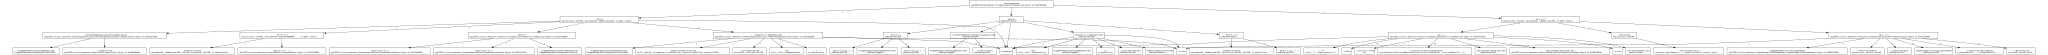

In [9]:
call_graph, _ = first_quantized_encoding.call_graph(generalizer=ignore_bookkeeping,max_depth=3)
show_call_graph(call_graph)

We can also look at the call graphs for the select or prepare in isolation.

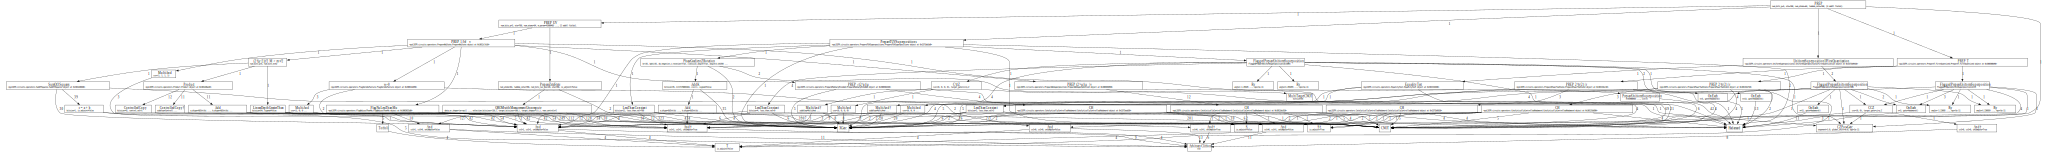

In [10]:
call_graph_prep, _ = first_quantized_encoding._prepare_gate.call_graph(generalizer=ignore_bookkeeping)
show_call_graph(call_graph_prep)

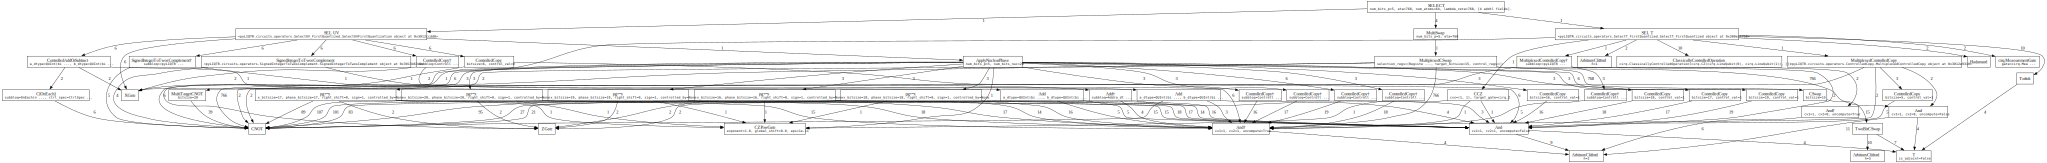

In [11]:
call_graph_sel, _ = first_quantized_encoding._select_gate.call_graph(generalizer=ignore_bookkeeping)
show_call_graph(call_graph_sel)

---
#### LIQTR Like 👍 : Circuit Scheduling
---

Circuits can be 'scheduled' using the `pyLIQTR.scheduler.scheduler.schedule_circuit` function. This will provide circuit runtime, realistic qubit counts, T-depth, and more!

`schedule_circuit` takes a number of optional arguments depending on desired outputs. They are:
* `architecture_config`: an `architecture` class object specifying gate times and state factory parameters. See `scheduling_example.ipynb` for details.

* `full_profile`: default `False`. If set to `True`, function output will include T-widths and parallelism distribution data. (NOTE: T-widths and parallelism data will only be accurate if `decomp_level` is set to `'Full'`.)

* `decomp_level`: int, default 0. Levels of decomposition implemented before scheduling. If set to `0`, each operator will be decomposed to one/two-qubit gates only on its first occurance and cached for each future occurance. If set to `'Full'`, entire circuit will be decomposed to one/two-qubit gates before scheduling. 

* `context` : cirq.DecompositionContext, default is none which will result in the use of a context manager that tries to minimize the number of ancilla generated. At times, certain Qualtran Bloqs may have an error in their decomposition which results in ancilla not being properly cleared. If this happens, we recommend passing `context=cirq.DecompositionContext(cirq.SimpleQubitManager())` to resolve this issue, at the cost of an overzealous qubit allocation.

* `rotation_gate_precision`: default 5e-6. Rotations are decomposed to a given precision. This can be passed explicitly using the `rotation_gate_precision` keyword argument. If no precision argument is provided, the default value will be used. Note that higher-precision will generally increase the resource cost.

For further details on scheduler capabilities, see `Algorithms_and_Infrastructure/scheduling_example.ipynb`.

For the case of the first quantized encoding, currently only the `SimpleQubitManager` is supported. This means that each time an ancilla is needed, the manager allocates a new qubit, i.e. previously allocated ancilla are not reused even if they are free. This is due to a known software bug and will be fixed in an upcoming release. Note that this style manager causes the qubit count to be greatly inflated.

In [3]:
# run the scheduler
from pyLIQTR.scheduler.scheduler import schedule_circuit
res = schedule_circuit(first_quantized_encoding.circuit, full_profile=True, decomp_level=0,context=cirq.DecompositionContext(qubit_manager=cirq.SimpleQubitManager()))
for r in res:
    print(f"{r} : {res[r]}")

Total time for execution : 95857900
Circuit T-depth : 296576
Number of qubits used : 12787
Gate profile : {'T': 349662, 'H': 114085, 'S': 6689, 'CX': 425907, 'Toffoli': 20, 'CZ': 6598, 'Pauli (X, Y, Z)': 8295, 'Miscellaneous': 13175}


---
#### LIQTR Like 👍 : Resource Analysis
---
Resource analysis of `cirq` circuits can be done by using the `pyLIQTR.utils.resource_analysis.estimate_resources` function, which will provide T, qubit, and Clifford counts for most circuits!

Note that our estimate for T-count is done via an experimentally derived statistical distribution for the Clifford count of rotations at a given precision. This can be set using one of two keyword arguments. The first is `rotation_gate_precision` (default = 1e-10), which specifies the maximum approximation error for each rotation. The second is `circuit_precision`, which overrides `rotation_gate_precision` if specified and sets the maximumum approximation error for each rotation to `circuit_precision` / $N_{\text{gates}}$, where $N_{\text{gates}}$ is the number of rotation gates in the given circuit element. If no precision argument is provided, the default value will be used.

In [13]:
estimate_resources(first_quantized_encoding)

{'LogicalQubits': 11913, 'T': 350054, 'Clifford': 575973}

---
#### LIQTR Like 👍 : Export of circuits to OpenQASM
---
Export of circuits can be done using a provided `pyLIQTR` utility (`pyLIQTR.utils.printing.openqasm`) that wraps `cirq`'s native openQASM export. This is introduced since some new qualtran operators do not yet have a decomposition in terms of gates defined, or `cirq` has begun to use features (mid-circuit measurement, classical control, etc) not supported by OpenQASM2.

This utility fully decomposes circuits to either include rotation gates (`rotation_allowed=True`) or not (`rotation_allowed=False`). 

In the latter case, we make use a of a Clifford+T representation outlined in https://arxiv.org/pdf/0806.3834.pdf (and further discussed in https://arxiv.org/pdf/1312.6584.pdf and http://www.cs.umd.edu/~amchilds/qa/qa.pdf, as potentially easier to digest forms).

When `rotation_allowed=False`, we introduce the "rx_d/ry_d/rz_d gate", followed by a line of the form:
```
// (leading_T, gate_sequence, sequence_length, clifford_part)
```
* `leading_T` : A bool indicating whether or not there is a `T` gate at the start of the sequence
* `gate_sequence`: An int whose binary representation encodes a sequence of `H`, `S`, and `T` gates
* `sequence_length`: The number of `T` gates in the sequence (note if `leading_T` is true, the total number of gates is `sequence_length+1`)
* `clifford_part`: A List[str] of clifford gates that come at the end of the H,S,T sequence.

Note that when `rotation_allowed=False`, you may also want to specify a level of precision by passing `gate_precision` or `circuit_precision` to `pyLIQTR.utils.printing.openqasm`. Also note that changing the qubit manager used for the decomposition context may result in errors.

In [3]:
for ctr,line in enumerate(openqasm(first_quantized_encoding.circuit,rotation_allowed=True,context=cirq.DecompositionContext(cirq.SimpleQubitManager()))):
    if ctr < 100:
        print(line)

// Generated from Cirq, Openfermion, and MIT LL

OPENQASM 2.0;
include "qelib1.inc";

// Qubits: [_c(171), _c(172), _c(173), _c(174), _c(175), _c(176), _c(177), _c(178), _c(179), _c(180), _c(181), _c(182), _c(183), _c(184), _c(185), _c(186), _c(187), _c(188), _c(189), _c(190), _c(191), _c(192), _c(193), _c(194), _c(195), _c(196), _c(197), _c(198), _c(199), _c(200), _c(201), _c(202), _c(203), _c(204), _c(205), _c(206), _c(207), _c(208), _c(209), _c(210), _c(211), _c(212), _c(213), _c(214), _c(215), _c(216), _c(217), _c(218), _c(219), _c(220), _c(221), _c(222), _c(223), _c(224), _c(225), _c(226), _c(227), _c(228), _c(229), _c(230), _c(231), _c(232), _c(233), _c(234), _c(235), _c(236), _c(237), _c(238), _c(239), _c(240), _c(241), _c(242), _c(243), _c(244), _c(245), _c(246), _c(247), _c(248), _c(249), _c(250), _c(251), _c(252), _c(253), _c(257), _c(258), _c(259), _c(260), _c(261), _c(262), _c(263), _c(264), _c(265), _c(266), _c(267), _c(268), _c(269), _c(270), _c(271), _c(272), _c(273), _c

---

# Application: resource estimates for magnesium systems

Now we'll look at resource estimates for the set of magnesium systems described in [Table 1](#tab1). We begin by defining a problem instance for each.  Here, we use values corresponding to $E_{\text{cut}}=40$ Ry, which is the target value for the magnesium models determined in [[2]](#ref2).

In [14]:
dimer_lengths=[12.7,12.7,19.9]
dimer = getInstance('MoleculeParameters',num_electrons=860,num_atoms=76,cell_volume=np.prod(dimer_lengths),sum_atomic_num=860,num_plane_waves=23750)

monolayer_lengths=[19.8,19.8,32.3]
monolayer = getInstance('MoleculeParameters',num_electrons=3344,num_atoms=335,cell_volume=np.prod(monolayer_lengths),sum_atomic_num=3344,num_plane_waves=89528)

cluster_lengths=[19.8,19.8,58.9]
cluster = getInstance('MoleculeParameters',num_electrons=8044,num_atoms=887,cell_volume=np.prod(cluster_lengths),sum_atomic_num=8044,num_plane_waves=163172)

supercell_lengths=[33.0,31.3,50.3]
supercell = getInstance('MoleculeParameters',num_electrons=10620,num_atoms=1107,cell_volume=np.prod(supercell_lengths),sum_atomic_num=10620,num_plane_waves=362880)

Next, we define the encodings. Here we want the error in our energy to be upper bounded my chemical accuracy, which corresponds to $\epsilon=10^{-3}$. Accordingly, we let $\epsilon_{\mathcal{M}}$=$\epsilon_R$=$\epsilon_T$=$\frac{\epsilon}{10}$ and solve for $\epsilon_{\text{pha}}$.

In [15]:
eps = 1e-3
eps_M = eps_T = eps_R = eps/10
eps_pha = np.sqrt(eps**2 - (eps_M+eps_R+eps_T)**2)

dimer_encoding = getEncoding(VALID_ENCODINGS.FirstQuantized, instance=dimer, eps_M=eps_M,eps_R=eps_R,eps_T=eps_T)

monolayer_encoding = getEncoding(VALID_ENCODINGS.FirstQuantized, instance=monolayer, eps_M=eps_M,eps_R=eps_R,eps_T=eps_T)

cluster_encoding = getEncoding(VALID_ENCODINGS.FirstQuantized, instance=cluster, eps_M=eps_M,eps_R=eps_R,eps_T=eps_T)

supercell_encoding = getEncoding(VALID_ENCODINGS.FirstQuantized, instance=supercell, eps_M=eps_M,eps_R=eps_R,eps_T=eps_T)

In order to compare to the estimates from [[2]](#ref2) which use the `LinearT` encoding, we will perform resource estimation for the full qubitized phase estimation circuit. Note that the larger models can take around two hours to execute, so the precomputed counts are included below.

In [16]:
dimer_qpe = QubitizedPhaseEstimation(dimer_encoding,eps=eps_pha)

monolayer_qpe = QubitizedPhaseEstimation(monolayer_encoding,eps=eps_pha)

cluster_qpe = QubitizedPhaseEstimation(cluster_encoding,eps=eps_pha)

supercell_qpe = QubitizedPhaseEstimation(supercell_encoding,eps=eps_pha)

In [ ]:
# dimer_resources = estimate_resources(dimer_qpe)
# print(dimer_resources)
# monolayer_resources = estimate_resources(monolayer_qpe)
# print(monolayer_resources)
# cluster_resources = estimate_resources(cluster_qpe)
# print(cluster_resources)
# supercell_resources = estimate_resources(supercell_qpe)
# print(supercell_resources)

# precomputed
dimer_resources = {'LogicalQubits': 13358, 'T': 845614636113880, 'Clifford': 1419757274462453}

monolayer_resources = {'LogicalQubits': 60735, 'T': 121526408878019456, 'Clifford': 192815306849382041}

cluster_resources = {'LogicalQubits': 145354, 'T': 1162238216384866800, 'Clifford': 1831855915985557833}

supercell_resources = {'LogicalQubits': 223645, 'T': 3556340673227587256, 'Clifford': 5519177836017269773}

<attrs generated getattr pyLIQTR.circuits.operators.PrepareZetaState.PrepareZetaState>:6: UserWarning: Desired precision 102 is beyond system spec 63. Using system spec instead. This will result in lower Clifford gate count.
  result = func(self)


{'LogicalQubits': 13358, 'T': 845614636113880, 'Clifford': 1419757274462453}


<attrs generated getattr pyLIQTR.circuits.operators.PrepareZetaState.PrepareZetaState>:6: UserWarning: Desired precision 117 is beyond system spec 63. Using system spec instead. This will result in lower Clifford gate count.
  result = func(self)


{'LogicalQubits': 60735, 'T': 121526408878019456, 'Clifford': 192815306849382041}


<attrs generated getattr pyLIQTR.circuits.operators.PrepareZetaState.PrepareZetaState>:6: UserWarning: Desired precision 123 is beyond system spec 63. Using system spec instead. This will result in lower Clifford gate count.
  result = func(self)


{'LogicalQubits': 145354, 'T': 1162238216384866800, 'Clifford': 1831855915985557833}


<attrs generated getattr pyLIQTR.circuits.operators.PrepareZetaState.PrepareZetaState>:6: UserWarning: Desired precision 126 is beyond system spec 63. Using system spec instead. This will result in lower Clifford gate count.
  result = func(self)


{'LogicalQubits': 223645, 'T': 3556340673227587256, 'Clifford': 5519177836017269773}


In [18]:
print(dimer_resources)
print(monolayer_resources)
print(cluster_resources)
print(supercell_resources)

{'LogicalQubits': 13358, 'T': 845614636113880, 'Clifford': 1419757274462453}
{'LogicalQubits': 60735, 'T': 121526408878019456, 'Clifford': 192815306849382041}
{'LogicalQubits': 145354, 'T': 1162238216384866800, 'Clifford': 1831855915985557833}
{'LogicalQubits': 223645, 'T': 3556340673227587256, 'Clifford': 5519177836017269773}


Finally, we can plot the results. Here we compare the resources estimated from the FirstQuantized circuit implementation to the LinearT implementation, as well as to the analytic and asymptotic expressions from [[1]](#ref1) and [[3]](#ref3).

In [19]:
# This cell calculates the expected Toffoli count based on Theorem 4 of [1]
def theorem4_count(lam,nT,n_p,nM,lambda_zeta,eta,nR,eps_pha,eps,br):
    n_eta = np.ceil(np.log2(eta))
    nEZ = np.ceil(np.log2(eta+2*lambda_zeta))
    pref = np.ceil(np.pi*lam/2/eps_pha)
    factor1 = 2*(nT+4*nEZ + 2*br-12) + 14*n_eta + 8*br - 36
    factor2 = 3*n_p**2 + 15*n_p - 7 + 4*nM*(n_p+1)
    row2 = lambda_zeta + 2+np.ceil(lambda_zeta/2) + 2*(2*n_p + 2*br -7) + 12*eta*n_p + 5*(n_p-1) + 2 + 24*n_p + 6*n_p*nR + 18
    row3 = nEZ + 2*n_eta + 6*n_p + nM + 16 + np.log2(1/eps)
    return pref*(factor1+factor2+row2+row3)

encodings = [dimer_encoding, monolayer_encoding, cluster_encoding, supercell_encoding]
param_dicts = {0:{},1:{},2:{},3:{}}
t4_counts = []
for i,enc in enumerate(encodings):
    param_dicts[i]['lam'] = enc.lam
    param_dicts[i]['nT'] = enc.n_T
    param_dicts[i]['n_p'] = enc.num_bits_p
    param_dicts[i]['nM'] = enc.n_M
    param_dicts[i]['lambda_zeta'] = enc.lambda_zeta
    param_dicts[i]['eta'] = enc.eta
    param_dicts[i]['nR'] = enc.n_R
    t4_counts.append(theorem4_count(**param_dicts[i],eps_pha=eps_pha,eps=eps,br=8))

In [20]:
t_counts_FQ = np.array([dimer_resources['T'],monolayer_resources['T'],cluster_resources['T'],supercell_resources['T']])
qubits_FQ = np.array([dimer_resources['LogicalQubits'],monolayer_resources['LogicalQubits'],cluster_resources['LogicalQubits'],supercell_resources['LogicalQubits']])

# These counts are taken from Reference [2] Table III
t_counts_LT = np.array([5.43e16,9.44e17,1.89e19,2.0e19])
qubits_LT = np.array([47665,179235,326530,725956])

n_pws = np.array([dimer.num_plane_waves,monolayer.num_plane_waves,cluster.num_plane_waves,supercell.num_plane_waves])
n_elecs = np.array([dimer.num_electrons,monolayer.num_electrons,cluster.num_electrons,supercell.num_electrons])

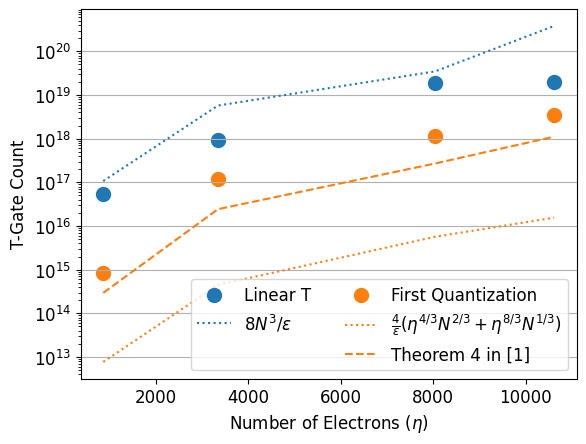

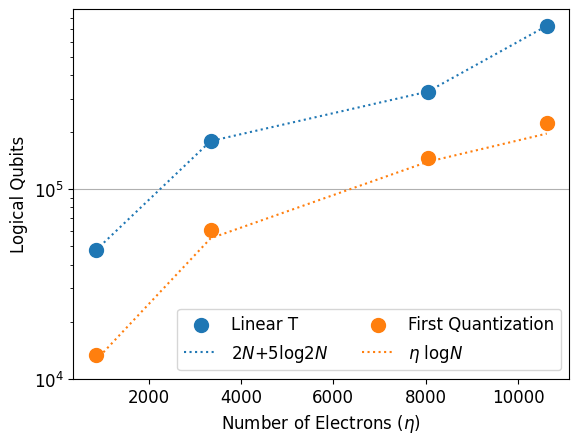

In [21]:
markersize = 100
plt.rc('font', size=12)
fig1, ax = plt.subplots()
fig2, ax2 = plt.subplots()

# t count plot
asymptotic_t_counts_FQ = [4*((int(eta)**4 * int(n_pws[i])**2)**(1./3) + (int(eta)**8 * int(n_pws[i]))**(1./3))/eps for i,eta in enumerate(n_elecs)]

ax.grid(axis='y')
ax.scatter(n_elecs, t_counts_LT,label='Linear T',s=markersize)
ax.plot(n_elecs,8*n_pws**3/eps,':',label=r'$8N^3/\epsilon$',color='tab:blue')
ax.plot(np.NaN, np.NaN, ':', color='none', label=' ')
ax.scatter(n_elecs, t_counts_FQ,label='First Quantization',s=markersize)
ax.plot(n_elecs,asymptotic_t_counts_FQ,':',label=r'$\frac{4}{\epsilon}(\eta^{4/3}N^{2/3} + \eta^{8/3}N^{1/3})$',color='tab:orange')
ax.plot(n_elecs,4*np.array(t4_counts),'--',label='Theorem 4 in [1]',color='tab:orange')

ax.set_xlabel("Number of Electrons ($\eta$)")
ax.set_ylabel("T-Gate Count")
ax.set_yscale('log')
ax.legend(ncol=2,loc='lower right')

# qubit plot
ax2.grid(axis='y')
ax2.scatter(n_elecs, qubits_LT,label='Linear T',s=markersize)
ax2.plot(n_elecs,2*n_pws + 5*np.log2(2*n_pws),':',label='2$N$+5log2$N$',color='tab:blue')
ax2.scatter(n_elecs, qubits_FQ,label='First Quantization',s=markersize)
ax2.plot(n_elecs,n_elecs*np.log2(n_pws),':',label='$\eta$ log$N$',color='tab:orange')

ax2.set_xlabel("Number of Electrons ($\eta$)")
ax2.set_ylabel("Logical Qubits")
ax2.set_yscale('log')
ax2.set_ylim(1e4)
ax2.legend(ncol=2,loc='lower right');

We find that the asymptotic expressions for logical qubit count match well with the circuit estimates, and that the FirstQuantized encoding qubit count is about 3x lower than the LinearT count. This factor would of course vary with the number of plane waves $N$. 

We also find that the T-gate count is ~10-100x lower for the FirstQuantized encoding compared to the LinearT. Interestingly, the analytic expression given in Theorem 4 Eq. 125 of [[1]](#ref1) (dashed orange) predicts a T-gate count that is within an order of magnitude of the estimates we get, but the asymptotic expression given in Eq. 26 of [[1]](#ref1) (dotted orange) predicts a T-gate count that is ~100x lower than our estimates. This demonstrates the importance of detailed gate counts based on the circuit composition.